# Python Text Analysis: Bag of Words

* * * 

<div class="alert alert-success">  
    
### Learning Objectives 
    
* Learn how to convert text data to a frequency matrix.
* Understand how TF-IDF complements the Bag-of-Words representation.
* Understand parameter settings of a vectorizer.
* Apply sentiment classification to vectorized text data.
</div>

### Icons Used in This Notebook
🔔 **Question**: A quick question to help you understand what's going on.<br>
🥊 **Challenge**: Interactive excersise. We'll work through these in the workshop!<br>

### Sections
1. [Exploratory Data Analysis](#section1)
2. [Preprocessing](#section2)
3. [The Bag-of-Words Representation](#section3)
4. [Term Frequency-Inverse Document Frequency](#section4)
5. [Sentiment Classification](#section5)

In [1]:
# Uncomment to install the following packages
# %pip install NLTK
# %pip install spaCy
# !python -m spacy download en_core_web_sm
# %pip install scikit-learn

In [2]:
# Import other packages
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
%matplotlib inline

In the previous part, we learned how to perform preprocessing NLP packages. However, we didn't move beyond the text data itself. If we're interested in doing any computational analysis on the text data, we'll need to devise approaches to convert the text into a **numeric representation**.

In Part 2 of our workshop series, we'll explore one of the most straightforward ways to generate a numeric representation from text: the **bag-of-words** (BoW). We will implement the BoW representation to transform our airline tweets data into numerical representation, and then biuld a classifier to explore what does it tell us about the sentiment of the tweets. At the heart of the bag-of-words approach lies the assumption that the frequency of specific tokens is informative about the semantics and sentiment underlying the text.

We'll make heavy use of the `scikit-learn` package to do so, as it provides a nice framework for constructing the numeric representations.

<a id='section1'></a>

# Exploratory Data Analysis

Before we ever do any preprocessing or modeling, we always should do some exploratory data analysis to get a feel for the dataset.

First, let's take a look at the first few rows and all the columns:

In [3]:
# Load dataset in
tweets_path = '../data/airline_tweets.csv'
tweets = pd.read_csv(tweets_path, sep=',')

In [4]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


As a refresher, each row in this dataframe correponds to a tweet. The following columns are of main interests to us:

- `text` (`str`): the text of the tweet.
- `airline_sentiment` (`str`): sentiment of the tweet, labeled as "neutral", "positive", or "negative". 
- `airline` (`str`): the airline that is tweeted about.
- `retweet count` (`int`): how many times the tweet was retweeted.

There are other columns indicating metadata of the tweet, such as the author of the tweet, when it was created, the timezone of the user, and others, which we will set aside for now. 

Let's take a look at a few tweets first!

In [5]:
# Print first five tweets
for idx in range(5):
    print(tweets['text'].iloc[idx])

@VirginAmerica What @dhepburn said.
@VirginAmerica plus you've added commercials to the experience... tacky.
@VirginAmerica I didn't today... Must mean I need to take another trip!
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
@VirginAmerica and it's a really big bad thing about it


We can already see that some of these tweets contain negative sentiment---how can we tell this is the case? 

Next, let's take a look at which airlines are tweeted about and how many of each in this dataset:

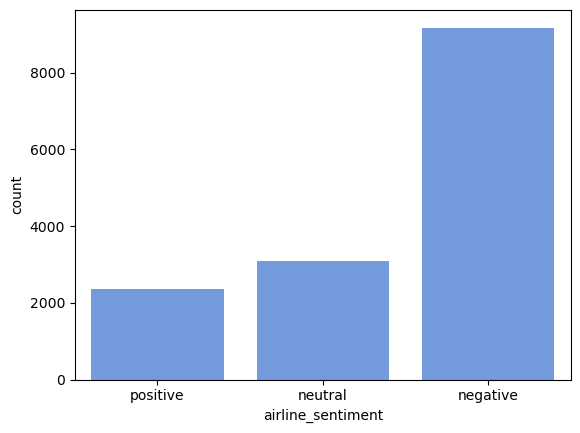

In [6]:
# Make a bar plot showing the count of tweet sentiments
sns.countplot(data=tweets,
              x='airline_sentiment', 
              color='cornflowerblue',
              order=['positive', 'neutral', 'negative']);

It looks like the majority of the tweets we have in this dataset are expressing negative sentiment!

Let's take a look at what gets more retweeted:

In [7]:
# Get the mean retweet count for each sentiment
tweets.groupby('airline_sentiment')['retweet_count'].mean()

airline_sentiment
negative    0.093375
neutral     0.060987
positive    0.069403
Name: retweet_count, dtype: float64

Negative tweets are clearly retweeted more often than tweets having neutral or positive sentiments.

Let's see which airline receives most negative tweets:

In [8]:
# Get the proportion of negative tweets by airline
proportions = tweets.groupby(['airline', 'airline_sentiment']).size() / tweets.groupby('airline').size()
proportions.unstack().sort_values('negative', ascending=False)

airline_sentiment,negative,neutral,positive
airline,,,
US Airways,0.776862,0.130793,0.092345
American,0.710402,0.167814,0.121783
United,0.688906,0.182365,0.128728
Southwest,0.490083,0.274380,0.235537
Delta,0.429793,0.325383,0.244824
Virgin America,0.359127,0.339286,0.301587


It looks like people are most dissatified with US Airways, followed by American Airline, both having over 70\% negative tweets!

A lot of interesting discoveries could be made if you want to explore more about the data. Now let's return to our task of sentiment analysis. Before that, we need to preprocess the text data so that they are in a standard format.

<a id='section2'></a>
# Preprocessing

We spent much of the last workshop learning how to preprocess data. Let's apply what we learned to this dataset. Looking at some of the tweets above, we can see that while they are in pretty good shape, we can do some additional processing on them.

In our pipeline, we'll omit the tokenization process, since we will perform it in a later step. 

## 🥊 Challenge 1: Apply a Text Cleaning Pipeline

Write a function called `preprocess()` that performs the following steps on a text input:
* Step 1: Lowercase text.
* Step 2: Replace the following patterns with placeholders:
    * URLs &rarr; ` URL `
    * Digits &rarr; ` DIGIT `
    * Hashtags &rarr; ` HASHTAG `
    * Tweet handles &rarr; ` USER `
* Step 3: Remove extra blankspaces.

Here are some hints to guide you through this challenge! 

* For Step 1, recall from Part 1 that a string method called [`.lower()`](https://docs.python.org/3.11/library/stdtypes.html#str.lower) will do the job of lowercasing text input.
* We have integrated Step 2 in a function called `placeholder`. Run the next cell to import it into your notebook, and you can use it just like any other functions.
* For Step 3, we have provided the regex pattern for identifying whitespace characters as well as the correct replacement for extraneous whitespaces. 

Run your `preprocess()` function on `example_tweet` (three cells below), and when you think you have it working, apply it to the entire `text` column in the tweets DataFrame.

In [9]:
from utils import placeholder

In [10]:
# blankspace_pattern = r'\s+'
# blankspace_repl = ' '

# def preprocess(text):
#     '''Create a preprocess pipeline that cleans the tweet data.'''
    
#     # Step 1: Lowercase
#     text = ...

#     # Step 2: Replace patterns with placeholders
#     text = ...

#     # Step 3: Remove extra whitespace characters
#     text = ...

#     return text

In [11]:
blankspace_pattern = r'\s+'
blankspace_repl = ' '

def preprocess(text):
    '''Create a preprocess pipeline that cleans the tweet data.'''

    # Step 1: Lowercase
    text = text.lower()

    # Step 2: Replace patterns with placeholders
    text = placeholder(text)

    # Step 3: Remove extra whitespace characters
    text = re.sub(blankspace_pattern, blankspace_repl, text)
    text = text.strip()
    
    return text

In [12]:
example_tweet = 'lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo'
# Print the example tweet
print(example_tweet)
print(f"{'='*50}")
# Print the preprocessed tweet
print(preprocess(example_tweet))

lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo
lol USER and USER are like soo DIGIT HASHTAG HASHTAG saw it on URL HASHTAG


In [13]:
# Apply the function to text column and assign the preprocessed tweets to a new column
tweets['text_processed'] = tweets['text'].apply(lambda x: preprocess(x))
tweets['text_processed'].head()

0                                 USER what USER said.
1    USER plus you've added commercials to the expe...
2    USER i didn't today... must mean i need to tak...
3    USER it's really aggressive to blast obnoxious...
4        USER and it's a really big bad thing about it
Name: text_processed, dtype: object

Ok now that preprocessing is complete. Let's dive into the bag-of-words!

<a id='section3'></a>
# The Bag-of-Words Representation

The idea of bag-of-words (BoW), as the name suggests, is quite intuitive: we take a document and toss it in a bag. The action of "throwing" the document in a bag disregards relative position between words, so what is "in the bag" is essentially an unsorted set of words [(Jurafsky & Martin, 2024, p.62)](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf). In return, we have a list of unique words and the frequency of each of them. 

For example, as shown in the following illustration, the word "coffee" appears twice. 

<img src='../images/bow-illustration-1.png' alt="BoW-Part2" width="600">

As you may have realized now, with a bag-of-words representation, we make heavy use of word frequency but not too much of word order. 

In the context of sentiment analysis, the sentiment of a tweet is conveyed more strongly by specific words. For example, if a tweet contains the word "happy", it likely conveys positive sentiment, but not always (e.g., "not happy" denotes the opposite sentiment). When these words come up more often, they'll probably more strongly convey the sentiment.

## Document Term Matrix

Now let's implement the idea of bag-of-words. Before we go deep into that, let's step back for a moment. In practice, text analysis often involves handling many documents; from now on, we use the term **document** to indicate a piece of text that we perform analysis on. It could be a phrase, a sentence, a tweet, and etc, as long as it could be represented by a string of text, the length dosen't really matter. 

Imagine we have four documents (i.e., the four phrases shown above), we toss them all in the bag. Instead of a word-frequency list, we would expect a document-term matrix (DTM) in return. In a DTM, the word list is the **vocabulary** (V) that holds all unique words occur across the documents. For each **document** (D), we count the number of occurence of each word in the vocabulary, and then plug the number into the matrix. In other words, the DTM we will need to construct is a $D \times V$ matrix, where each row corresponds to a document, and each column corresponds to a token (or "term").

In the following example, the unique tokens in this set of documents, in alphabetical order, are in columns. For each document, we mark the occurence of each word showing up in the document. The numerical representation for each document is a row in the matrix. For example, "the coffee roaster" or the first document has numerical representation $[0, 1, 0, 0, 0, 1, 1, 0]$.

Note that the left index column now displays these documents as texts, but typically we would just assign an index to each of them. 

$$
\begin{array}{c|cccccccccccc}
 & \text{americano} & \text{coffee} & \text{iced} & \text{light} & \text{roast} & \text{roaster} & \text{the} & \text{time} \\\hline
\text{the coffee roaster} &0 &1	&0	&0	&0	&1	&1	&0 \\ 
\text{light roast} &0 &0	&0	&1	&1	&0	&0	&0 \\
\text{iced americano} &1 &0	&1	&0	&0	&0	&0	&0 \\
\text{coffee time} &0 &1	&0	&0	&0	&0	&0	&1 \\
\end{array}
$$

To create a DTM, we will use `CountVectorizer` from the package `sklearn`.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

If you're not familiar with `CountVectorizer`, here is the general workflow:

<img src='../images/CountVectorizer1.png' alt="CountVectorizer" width="500">

Let's walk through these steps with the toy example shown above.

### A Toy Example

In [15]:
# A toy example containing four documents (phrases)
test = ['the coffee roaster',
        'light roast',
        'iced americano',
        'coffee time']

The first step is to initialize a `CountVectorizer` object. Within the round paratheses is the parameter setting we may choose to specify. Let's take a look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and see what options are available.  

For now we can just leave it blank for the default setting. 

In [16]:
# Create a CountVectorizer object
vectorizer = CountVectorizer()

The second step is to `fit` this `CountVectorizer` object to the data, which means creating a vocabulary of tokens from the set of documents. Thirdly, we `transform` our data according to the "fitted" `CountVectorizer` object, which means taking each of the document and transforming it into a DTM according to the vocabulary established by the "fitting" step.

It may sound a bit complex but steps 2 and 3 can actually be done in one swoop using a `fit_transform` function.

In [17]:
# Fit and transform to create DTM
test_count = vectorizer.fit_transform(test)

The return of `fit_transform` is supposed to be the DTM. 

Let's take a look at it!

In [18]:
test_count

<4x8 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

Apparently the return is a "sparse matrix"---a matrix that contains a lot zeros. It actually makes sense as for each document we definitely have words that don't occur at all---which is counted zero in the DTM. This sparse matrix is stored in a "Compressed Sparse Row" format, which is a memory-saving format that is designed to deal with sparse matrix. 

Let's convert it to a dense matrix, where those zeros are probably organized, as in a numpy array.

In [19]:
# Convert DTM to a dense matrix 
test_count.todense()

matrix([[0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1]])

So this is our DTM! It is the same as shown above, but to make it more reader-friendly, let's convert it to a dataframe. The column names should be tokens in the vocabulary, which we can access with `get_feature_names_out()`.

In [20]:
# Retrieve the vocabulary
vectorizer.get_feature_names_out()

array(['americano', 'coffee', 'iced', 'light', 'roast', 'roaster', 'the',
       'time'], dtype=object)

In [21]:
# Create a DTM dataframe
test_dtm = pd.DataFrame(data=test_count.todense(),
                        columns=vectorizer.get_feature_names_out())

Here it is! The DTM of our toy data is now a dataframe. The index of `test_dtm` corresponds to the position of each document in the `test` list. 

In [22]:
test_dtm

,americano,coffee,iced,light,roast,roaster,the,time
0,0,1,0,0,0,1,1,0
1,0,0,0,1,1,0,0,0
2,1,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,1


Hopefully we all have understood the steps involved in constructing a DTM. 

Let's turn to our tweet data!

### DTM for Tweets

We'll still begin with initializing a `CountVectorizer` object. In the following cell, we have included a few parameters that people often adjust. These parameters are currently set to their default values.

As shown below, when we construct a DTM, the default is to lowercase the input text. If nothing is provided for `stop_words`, the default is to keep them. The next three parameters are used to control the number of tokens, which we'll return to in a minute!

In [23]:
# Create a CountVectorizer object
vectorizer = CountVectorizer(lowercase=True,
                             stop_words=None,
                             min_df=1,
                             max_df=1.0, 
                             max_features=None)

In [24]:
# Fit and transform to create DTM
counts = vectorizer.fit_transform(tweets['text_processed'])
counts

<14640x9913 sparse matrix of type '<class 'numpy.int64'>'
	with 230849 stored elements in Compressed Sparse Row format>

In [25]:
# Do not run if you have limited memory - this includes DataHub and Binder
np.array(counts.todense())

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [26]:
# Extract tokens
tokens = vectorizer.get_feature_names_out()

In [27]:
# Create DTM
first_dtm = pd.DataFrame(data=counts.todense(),
                         index=tweets.index,
                         columns=tokens)

# Print the shape of DTM
print(first_dtm.shape)

(14640, 9913)


If we leave the `CountVectorizer` to the default setting, in total we have a vocabulary size of 9913. 

Let's take a closer look at the DTM.

In [28]:
first_dtm.head()

,_exact_,_wtvd,aa,aaaand,aadavantage,aadv,aadvantage,aal,aaron,ab,...,zero,zig,zip,zippers,zone,zones,zoom,zukes,zurich,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Most of the tokens have zero occurences at least in the first five tweets. Let's take a closer look at the DTM!

In [29]:
# Most frequent tokens
first_dtm.sum().sort_values(ascending=False).head(10)

user      16500
to         8653
digit      8427
the        6063
you        4401
for        4001
flight     3935
on         3815
and        3733
my         3288
dtype: int64

In [30]:
# Least frequent tokens
first_dtm.sum().sort_values(ascending=True).head(10)

_exact_      1
minus        1
minssss      1
minors       1
minonhold    1
minimal      1
mini         1
minflight    1
mines        1
mindset      1
dtype: int64

It is not surprising to see "user" and "digit" to be among the most frequent tokens as we replaced each idiosyncratic one to these placeholders. The rest of the most frequent list are mostly stop words.

Perhaps a more interesting pattern is to look for which token appears most in any given tweet:

In [31]:
counts = pd.DataFrame()
# Retrieve the index to the tweet where each token appears most frequently
counts['token'] = first_dtm.idxmax(axis=1)
# Retrieve the number of occurence 
counts['number'] = first_dtm.max(axis=1)
# Filter out placeholders
counts[(counts['token'] != 'digit')
       & (counts['token'] != 'hashtag')
       & (counts['token'] != 'user')].sort_values('number', ascending=False).head(10)

,token,number
3915,lt,6
1214,worst,6
10173,to,5
3412,to,5
792,to,5
6469,to,5
13715,to,5
10614,the,5
14030,to,5
10599,to,5


It looks like among all tweets, at most a token appears 6 times, and it is either the word "It" or the word "worst". 

Let's go back to our tweets dataframe and get the 1214th tweet.

In [32]:
# Look at index 1214: "worst"
tweets.iloc[1214]['text']

"@united is the worst. Worst reservation policies. Worst costumer service. Worst worst worst. Congrats, @Delta you're not that bad!"

## Customizing the `CountVectorizer`

So far we've sticked to the default parameter setting to create our DTMs, but in many cases we may want to customize the `CountVectorizer` object. The purpose of doing so is to further filter out words that do not contribute to the meaning of the data. In the example below, we tweak the following parameters:

- `stop_words = 'english'`: exclude English stop words 
- `min_df = 2`: exclude words don't occur at least twice
- `max_df = 0.95`: exclude words if they occur in more than 95\% of the documents

🔔 **Question**: Let's pause for a minute to discuss if it is reasonable to set these parameters! What do you think?

As you can see, typically we are not interested in words whose frequencies are either too low or too high, so we go to `min_df` and `max_df` to trim them out. Alternatively, we can also define our vocabulary size to be $N$, and let it be `max_feature`---we are telling `CountVectorizer` to only consider the top $N$ most frequent features when construct the DTM.

In [33]:
# Customize the parameter setting
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

In [34]:
# Fit, transform, and get tokens
counts = vectorizer.fit_transform(tweets['text_processed'])
tokens = vectorizer.get_feature_names_out()

# Create the second DTM
second_dtm = pd.DataFrame(data=counts.todense(),
                   index=tweets.index,
                   columns=tokens)

Our second DTM has a substantially smaller vocabulary, compared to the first one.

In [35]:
print(first_dtm.shape)
print(second_dtm.shape)

(14640, 9913)
(14640, 5152)


In [36]:
second_dtm.head()

,aa,aadv,aadvantage,aal,abandoned,abc,abi,abilities,ability,able,...,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The most frequent token list now includes words that make more sense to us, for example, "flight", "cancelled", "service", and etc. 

In [37]:
second_dtm.sum().sort_values(ascending=False).head(10)

digit        8427
flight       3935
hashtag      3243
url          1211
thanks       1078
cancelled    1057
just          974
service       965
help          855
time          793
dtype: int64

## 🥊 Challenge 2: Lemmatize the Text Input

Recall from Part 1 that we introduced using `spaCy` to perform lemmatization, i.e., removing morphological affixes on words. With lemmatization, we keep only word stems in texts, which presumbaly should capture the core meaning of the text. 

Now let's implement lemmatization on our tweet data, and pass the lemmatized text to create a third DTM. 

Complete the function `lemmatize_text`. It requires a text input, and the returned output is the same text except this time lemmas of all tokens. There are several steps we need to consider to complete this function:
- Initialize a list to hold lemmas
- Apply the `nlp()` pipeline to input text
- Iterate over tokens in the processed text, and retrieve lemma of the token
    - HINT: lemma is one of the linguistic annotations that the `nlp` pipeline returns. We can use `token.lemma_` to access the annotation.

In [38]:
# Import spaCy
import spacy
nlp = spacy.load('en_core_web_sm')

In [39]:
# # Create a function to lemmatize text
# def lemmatize_text(text):
#     '''Lemmatize the text input with spaCy annotations.'''

#     # Step 1: Initialize an empty list to hold lemmas
#     lemma = ...

#     # Step 2: Apply the nlp pipeline to input text
#     doc = ...

#     # Step 3: Iterate over tokens in the text to get the token lemma
#     for token in doc:
#         lemma.append(...)

#     # Step 4: Join lemmas together into a single string
#     text_lemma = ' '.join(lemma)
    
#     return text_lemma

In [40]:
# Create a function to lemmatize text
def lemmatize_text(text):
    '''Lemmatize the text input with spaCy annotations.'''

    # Step 1: Initialize an empty list to hold lemmas
    lemma = []

    # Step 2: Apply the nlp pipeline to input text
    doc = nlp(text)

    # Step 3: Iterate over tokens in the text to get the token lemma
    for token in doc:
        lemma.append(token.lemma_)

    # Step 4: Join lemmas together into a single string
    text_lemma = ' '.join(lemma)
    
    return text_lemma

In [41]:
# Apply the function to an example tweet
print(tweets.iloc[101]["text_processed"])
print(f"{'='*50}")
print(lemmatize_text(tweets.iloc[101]['text_processed']))

USER why must a traveler miss a flight to late flight check a bag? i missed my morning appointments and you lost my business. HASHTAG DIGIT lax
USER why must a traveler miss a flight to late flight check a bag ? I miss my morning appointment and you lose my business . HASHTAG DIGIT lax


In [42]:
# This may take a while!
tweets['text_lemmatized'] = tweets['text_processed'].apply(lambda x: lemmatize_text(x))

In [43]:
# Print the preprocessed tweet
print(tweets['text_processed'].iloc[101])
print(f"{'='*50}")
# Print the lemmatized tweet
print(tweets['text_lemmatized'].iloc[101])

USER why must a traveler miss a flight to late flight check a bag? i missed my morning appointments and you lost my business. HASHTAG DIGIT lax
USER why must a traveler miss a flight to late flight check a bag ? I miss my morning appointment and you lose my business . HASHTAG DIGIT lax


In [44]:
# Create the vectorizer (the same param setting as previous)
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

# Fit, transform, and get tokens
counts = vectorizer.fit_transform(tweets['text_lemmatized'])
tokens = vectorizer.get_feature_names_out()

# Create the third DTM
third_dtm = pd.DataFrame(data=counts.todense(),
                   index=tweets.index,
                   columns=tokens)
third_dtm.head()

,aa,aadv,aadvantage,aal,abandon,abc,abi,ability,able,aboard,...,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# Print the shapes of three DTMs
print(first_dtm.shape)
print(second_dtm.shape)
print(third_dtm.shape)

(14640, 9913)
(14640, 5152)
(14640, 4097)


In [46]:
# Get the most frequent tokens in the third DTM
third_dtm.sum().sort_values(ascending=False).head(10)

digit      8427
flight     4844
hashtag    3243
thank      1679
url        1211
hour       1166
cancel     1048
service    1000
delay       986
just        974
dtype: int64

<a id='section4'></a>

# Term Frequency-Inverse Document Frequency 

So far, we're relying on word frequencies to give us information about a document. This assumes if a word appears more often in a document, it's more informative. However, this may not always be the case. For example, we've already removed stop words because they are not informative, despite the fact that they appear many times in a document. We also know the word "flight" is among the most frequent words, but it is also not that informative, because it appears in many documents. Since we're looking at airline tweets, we shouldn't be surprised to see the word "flight"!

To remedy this, we use a weighting scheme called **tf-idf (term frequency-inverse document frequency)**. The big idea behind tf-idf is to weight a word not just by its frequency within a document, but by its frequency in one document relative to the remaining documents. For words that frequently appearing in almost all documents, we want to scale its frequency down. For words that distinctively appear in a set of but not all documents, we want to scale its frequency up because they are likely to be more informative to this set of document.

So, when we construct the DTM, we will be assigning each term a **tf-idf score**. Specifically, term $t$ in document $d$ is assigned tf-idf score as follows:

<img src='../images/tf-idf.png' alt="TF-IDF" width="1200">

In essence, the tf-idf score of a word in a document is the product of two components: term frequency (tf) and inverse document frequency (idf). The idf acts as a scaling factor. If a word occurs in all documents, then idf equals to 1, no scaling will happen. But idf is typically greater than 1, which is the weight we assign to the word to make the tf-idf score higher, so as to highlight that the word is informative. In practice, we add 1 to both the denominator and nominator ("add-1 smooth"), to prevent any issues with zero occurrences.

We can also create a tf-idf DTM using `sklearn`. We'll use a `TfidfVectorizer` this time:

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [48]:
# Create a tfidf vectorizer
vectorizer = TfidfVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

In [49]:
# Fit and transform 
tf_dtm = vectorizer.fit_transform(tweets['text_lemmatized'])
tf_dtm

<14640x4097 sparse matrix of type '<class 'numpy.float64'>'
	with 107285 stored elements in Compressed Sparse Row format>

In [50]:
# Create a tf-idf dataframe
tfidf = pd.DataFrame(tf_dtm.todense(),
                     columns=vectorizer.get_feature_names_out(),
                     index=tweets.index)
tfidf.head()

,aa,aadv,aadvantage,aal,abandon,abc,abi,ability,able,aboard,...,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


You may have noticed that we still have the same vocabulary size as we saw in Challenge 2, this is because we sticked to the same parameter setting when creating the vectorizer. But the values in the matrix are different now---they are tf-idf scores inseatd of raw counts. 

## Interpret TF-IDF Values

Let's take a look the document where a term has the highest tf-idf values.

We'll use `idxmax()` to find the index to the document.

In [51]:
# Retrieve the index to the document
tfidf.idxmax()

aa             1061
aadv          11933
aadvantage    12813
aal           13588
abandon       10288
              ...  
zero           3367
zone           3975
zoom           4970
zurich        13583
zz             6679
Length: 4097, dtype: int64

For example, the term "worst" occurs distinctively in the 1214th tweet, let's retrieve the tweet!

In [52]:
tfidf.idxmax()['worst']

1214

It turns out to be the 1214th tweet---recall from previous part that it is the tweet where the word "worst" appears 6 times!

In [53]:
tweets['text_processed'].iloc[1214]

"USER is the worst. worst reservation policies. worst costumer service. worst worst worst. congrats, USER you're not that bad!"

How about "cancel"? Let's take a look at another one!

In [54]:
tfidf.idxmax()['rude']

563

In [55]:
tweets['text_processed'].iloc[7840]

'USER cancelled flighted 😢'

## 🥊 Challenge 3: Words with Highest Mean TF-IDF scores

So we have got tf-idf values for each term in each document, does that inform us anything about our data? Instead of focusing on tf-idf value of any particular word, let's take a step back. Is there any word to be particularly informative for positive/negative tweets? Let's gather the indices to all positive/negative tweets, and calculate the mean tf-idf scores of words appear in positive/negative tweets. 

We've provided the following starter codes to scaffold:
- Use boolean masks to select tweets that have positive/negative sentiments, retrieve the indices, and assign them to `positive_index`/`negative_index`
- Select positive/negative tweets in the tfidf dataframe, and take the mean tf-idf values across the documents, sort the mean values in descedning order, and get the top 10 terms. 

After you've completed the following two cells, plot the words having the highest mean tf-idf scores for each subset. 

In [56]:
# # Complete the boolean masks 
# positive_index = tweets[...].index
# negative_index = tweets[...].index

In [57]:
# # Complete the following two lines
# pos = tfidf.loc[...].mean().sort_values(...).head(...)
# neg = tfidf.loc[...].mean().sort_values(...).head(...)

In [58]:
positive_index = tweets[tweets['airline_sentiment'] == 'positive'].index
negative_index = tweets[tweets['airline_sentiment'] == 'negative'].index

pos = tfidf.loc[positive_index].mean().sort_values(ascending=False).head(10)
neg = tfidf.loc[negative_index].mean().sort_values(ascending=False).head(10)

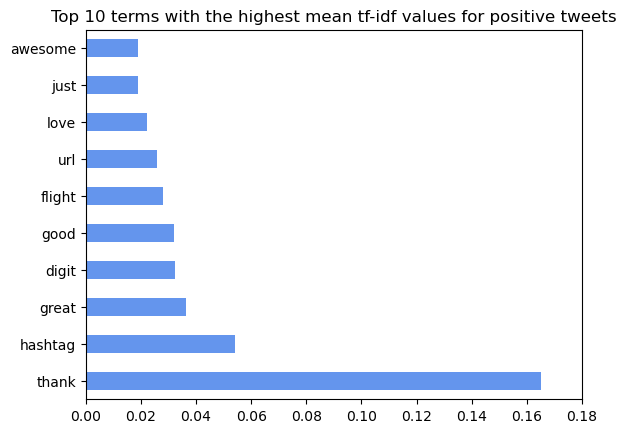

In [59]:
pos.plot(kind='barh', 
         xlim=(0, 0.18),
         color='cornflowerblue',
         title='Top 10 terms with the highest mean tf-idf values for positive tweets');

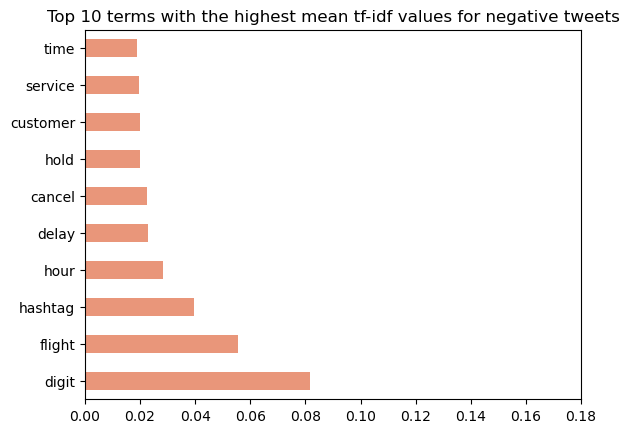

In [60]:
neg.plot(kind='barh', 
         xlim=(0, 0.18),
         color='darksalmon',
         title='Top 10 terms with the highest mean tf-idf values for negative tweets');

🔔 **Question**: How do you interpret these two plots? Is there any word that dosn't really make sense to you?

<a id='section5'></a>
# Sentiment Classification

Now that we have a numerical representation of the text, we'd like to do something with it. A common task is supervised learning: using the numerical representation to predict some kind of label about the text. Text classification can consist of many types of analysis, such as:

* Sentiment analysis
* Genre classification
* Language identification
* Authorship attribution
* Spam detection
* Document relevancy

and many others. How exactly do we go about doing this?

Let's consider a toy example: "This was the best service! Would love to come again!"

This is very clearly expressing positive sentiment. But how did we make that judgement?

* The review claims the service is the "best". This is pretty positive.
* The reviewer says they would "love" to come again. This is also positive.

Specific key words (tokens) were predictive of the sentiment. If someone says something was the "best", it's a good sign there's positive sentiment in the text. The semantic meaning of these words helps convey sentiment. 

This is how we can proceed with classification. We'll construct a DTM from the text data, and use that to predict the labels using a machine learning model.

## Predicting Sentiment with Logistic Regression

We're going to use a logistic regression model to predict the labels. If you're not familiar with this model, or the basics of machine learning, we recommend taking the [Python Machine Learning Fundamentals](https://github.com/dlab-berkeley/Python-Machine-Learning) offered at the D-Lab. For now, we'll review some basics.

The DTM is a $D\times T$ matrix, where $D$ is the number of documents, and $T$ is the number of terms. We can think of the $T$ terms as the "features": these values are what we'll use to predict the sentiment. The $D$ documents represent samples: we'll use the patterns across these samples to learn a relationship between the feature and the outcome.

In logistic regression, we are learning a **linear model** represented by specific parameters, which we'll call $\beta_i$. For features $x_i$ (this is a row in the DTM), we construct a **logit**:

$$
L = \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_T x_T
$$

and obtain a probability $p$ by passing this logit through the **sigmoid function**, which maps any value onto the range $[0, 1]$:

$$
p = \text{sigmoid}(L) = \frac{1}{1 + \exp(-L)}
$$

We can quite literally think of $p$ as a probability that the sample falls in one of the two classes. If, say, $p>0.5$, we call the sample positive sentiment; otherwise, it's negative sentiment.

So, to summarize: we take each sample, which consists of features $x = (x_1, x_2, \ldots, x_T)$, multiply them by $\beta_i$ values, and add them up. Pass them through a sigmoid, and get a probability. The key question is: how do we know what $\beta_i$ values to use? We won't discuss thus details here, but an optimization algorithm will learn the best values given the data. 

Let's train a model! We're going to use `sklearn` to do this:

In [61]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

To understand the theoretical gist of our classification task, let's first focus on a binary "positive vs negative" classifier. We are going to do so by restricting the analysis to the non-neutral tweets. So, we'll first partition the dataframe:

In [62]:
# Filter out tweets with neutral sentiment
tweets_binary = tweets[tweets['airline_sentiment'] != 'neutral']
tweets_binary.shape

(11541, 17)

Next, we're going to apply a tf-idf vectorizer to the data. We will apply the vectorizer to the lemmatized text. 

In [63]:
# Create a tfidf vectorizer object
vectorizer = TfidfVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

# Fit and transform
dtm = vectorizer.fit_transform(tweets_binary['text_lemmatized'])

# Get the tfidf values - features fed into the classifier
X = np.asarray(dtm.todense())

# Print the shape of the features
print(X.shape)

(11541, 3553)


Now, we need to get the labels for each of the 11,541 tweets. We can do this by simply extracting the `airline_sentiment` column---`sklearn` is smart enough to handle the details later. Let's also check out the distribution of the labels, to get a sense for a good baseline:

In [64]:
# Get the proporation of each class
y = tweets_binary['airline_sentiment']
print(y.value_counts())

airline_sentiment
negative    9178
positive    2363
Name: count, dtype: int64


Machine learning fundamentally requires that we learn the $\beta_i$ values from a **training set**, and then evaluate the performance on a separately held **test set**. This ensures that we actually develop an algorithm that can **generalize**. We'll use the `train_test_split` function from `sklearn` to separate our data into two sets:

In [65]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In order to streamline the training process, we've written a `fit_logistic_regression` function you can use to easily train a model given the data inputs. 

Given the positive and positive classes are not balanced, we can tell the classifier to automatically assigning weights (i.e, the `class_weight` parameter) proportional to our data in order to have pay more attention to the minority class.

In [66]:
def fit_logistic_regression(X, y):
    '''Fits a logistic regression model to provided data.'''
    model = LogisticRegressionCV(Cs=10,
                                 penalty='l1',
                                 cv=5,
                                 solver='liblinear',
                                 class_weight='balanced',
                                 random_state=42,
                                 refit=True).fit(X, y)
    return model

We'll fit the model, and see how it performs on both the training and test sets:

In [67]:
# Fit the logistic regression model
model = fit_logistic_regression(X_train, y_train)

In [68]:
print(f"Training accuracy: {model.score(X_train, y_train)}")
print(f"Test accuracy: {model.score(X_test, y_test)}")

Training accuracy: 0.9457640941992048
Test accuracy: 0.8943418013856813


The model got ~94% accuracy on the training set, and ~89% on the test set - that's pretty good! The similarity between the two performances is also a good sign - it means we were able to generalize pretty well.

## Validating Model Performance on New Tweets

Now that we have a trained model, there's nothing stopping us from using it on new data! The `model` object comes equipped with a `predict` function that we can use to evaluate on new text samples:

In [69]:
# Some new tweets
new_tweets = ["It's been 10hrs of delay @United please do your job.",
              'omg I am never flying on United again',
              'I love @VirginAmerica so much #friendlystaff',
              'food on Air France is great!']

# First, we need to preprocess them
new_tweets_processed = [lemmatize_text(preprocess(tweet)) for tweet in new_tweets]

# Next, we need to vectorize them
X_new = np.asarray(vectorizer.transform(new_tweets_processed).todense())

In [70]:
# Run predictions
model.predict(X_new)

array(['negative', 'positive', 'positive', 'positive'], dtype=object)

In [71]:
# Get probabilities
predicts = model.predict_proba(X_new)
predicts

array([[9.99231265e-01, 7.68735435e-04],
       [2.91861015e-01, 7.08138985e-01],
       [5.84585925e-04, 9.99415414e-01],
       [9.28247816e-02, 9.07175218e-01]])

In [72]:
# Retrieve the probability of being positive for each tweet
for i, tweet in enumerate(new_tweets):
    print(f"For the new tweet: {tweet}\n"
          f"The probability of being positive is {predicts[i][1]:.3f}\n")

For the new tweet: It's been 10hrs of delay @United please do your job.
The probability of being positive is 0.001

For the new tweet: omg I am never flying on United again
The probability of being positive is 0.708

For the new tweet: I love @VirginAmerica so much #friendlystaff
The probability of being positive is 0.999

For the new tweet: food on Air France is great!
The probability of being positive is 0.907



Those predictions look pretty good! Feel free to give the model a try on other tweets you write.

## Interpreting the Model Coefficients

The nice thing about logistic regression is that it is **interpretable**. Take a look at the logit again:

$$
L = \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_T x_T
$$

If $L$ is very positive, the sigmoid will make sure that the probability $p$ is close to 1 (positive sentiment). If $L$ is very negative, the sigmoid will make sure that the probability $p$ is close to 0 (negative sentiment). So, by looking at the coefficients $\beta_i$, we can see how each feature (token) impacts the eventual prediction. If $\beta_i >0$, then the presence of that feature implies positive sentiment, according to the model. If  $\beta_i < 0$, then the presence of that feature implies negative sentiment, according to the model.

So, let's take a look at the fitted coefficients to see if what we see makes sense! We can access them using the `coef_` member, and we can match each coefficient to the tokens from the vectorizer:

In [73]:
# Get coefs of all features
coefs = model.coef_.ravel()

# Get all tokens
tokens = vectorizer.get_feature_names_out()

# Create a token-coef dataframe
importance = pd.DataFrame()
importance['token'] = tokens
importance['coefs'] = coefs

In [74]:
# Take a look the dataframe
importance.head()

,token,coefs
0,aa,-1.036589
1,aadv,0.000000
2,aadvantage,0.000000
3,aal,0.000000
4,abandon,0.000000


In [75]:
# Get the top 10 tokens with lowest coefs
neg_coef = importance.sort_values('coefs').head(10)
neg_coef

,token,coefs
2724,rude,-10.525223
2727,ruin,-10.393126
2784,screw,-9.966122
1505,hour,-8.786973
1135,fail,-8.622449
1513,hrs,-8.555808
2280,pay,-7.745916
1798,lie,-7.617869
458,cancel,-7.579262
264,bad,-7.391406


In [76]:
# Get the top 10 tokens with highest coefs
pos_coef = importance.sort_values('coefs').tail(10)
pos_coef

,token,coefs
3165,thankful,7.779449
616,comfortable,8.025640
1091,exceptional,8.172147
1089,excellent,8.538358
1861,love,8.804008
250,awesome,9.340841
1373,great,9.451670
3498,wonderful,9.518228
1746,kudo,10.288397
3164,thank,17.115641


Similar to tf-idf values, we can also plot the top 10 tokens with the highest/lowest coefficients. 

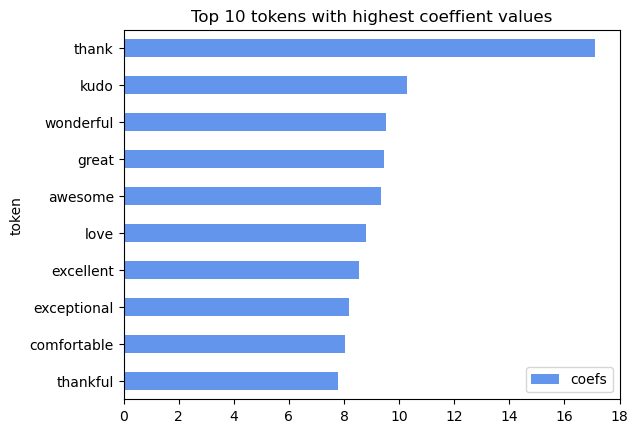

In [77]:
# Plot the top 10 tokens that have the highest coefs
pos_coef.plot(kind='barh', 
              xlim=(0, 18),
              x='token',
              color='cornflowerblue',
              title='Top 10 tokens with highest coeffient values');

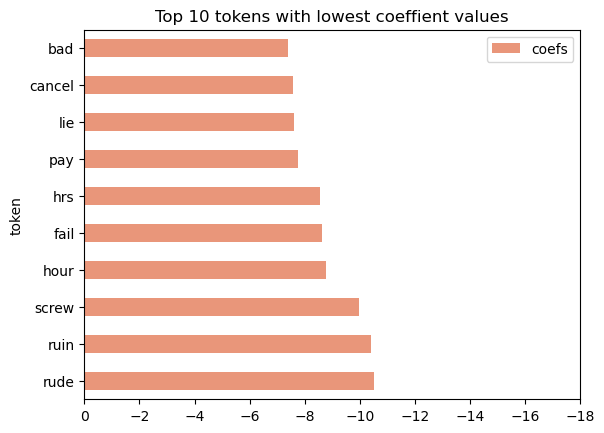

In [78]:
# Plot the top 10 tokens that have the lowest coefs
neg_coef.plot(kind='barh', 
              xlim=(0, -18),
              x='token',
              color='darksalmon',
              title='Top 10 tokens with lowest coeffient values');

This makes sense! Tokens like "ruin", "rude", and "hrs" imply negative sentiment, while tokens like "thank", "awesome", "wonderful" imply positive sentiment. 

🔔 **Question**: Compare these two plots with the previous two on tf-idf values. What you have noticed? What does this tell you about how people use this token in their tweets?

<div class="alert alert-success">

## ❗ Key Points

* A Bag-of-Words representation is a simple method to transform our text data to numbers. It focuses on word frequency but not word order. 
* A TF-IDF representation is a step further; it also considers if a certain word distinctively appears in one document or occurs uniformally across all documents. 
* With a numerical representation, we can perform a range of text classification task, such as sentiment analysis. 

</div>